In [1]:
import pandas as pd
import os
import requests
from api import CENSUS_API_KEY
import ssl
from util.convertfile import *
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
epa_df = pd.read_csv("~/Documents/UH/hon4350/water_quality/data/main/filtered_epa_tri.csv")
acs_df = pd.read_csv("~/Documents/UH/hon4350/water_quality/data/main/filtered_census_acs_5yr.csv")

In [4]:
acs_df["zip"] = acs_df["zip"].astype(str).str.zfill(5)
epa_df["zip"] = epa_df["zip"].astype(str).str.zfill(5)

merged_df = pd.merge(epa_df, acs_df, left_on=["zip", "year"], right_on=["zip", "year"], how="left")
merged_df

,year,trifd,frs_id,facility_name,street_address,city,county,state,zip,zip+4,latitude,longitude,horizontal_datum,parent_co_name,parent_co_db_num,federal_facility,industry_sector_code,industry_sector,chemical,elemental_metal_included,tri_chemical/compound_id,classification,metal,metal_category,carcinogen,unit_of_measure,released_water,total_population,total_housing_units,housing_pre1980,median_household_income,gini_index,white_alone,black_alone,asian_alone,hispanic_alone,pct_white,pct_black,pct_asian,pct_hispanic,pct_pre1980_housing
0,2016,7545WMLSSP828NH,1.100128e+11,MELISSA PLANT,8280 N HWY 5,MELISSA,COLLIN,TX,75454,0,33.310199,-96.559305,NAD83,NaN,NaN,NO,327,Nonmetallic Mineral Product,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,0.001,3171.0,1113.0,238.0,72147.000,0.336,2347.0,100.0,27.0,685.0,0.740,0.032,0.009,0.216,0.214
1,2016,77028NLCXX46HME,1.100253e+11,NELCO,4600 HOMESTEAD RD,HOUSTON,HARRIS,TX,77028,0,29.803290,-95.301800,NAD83,NELCO,NaN,NO,332,Fabricated Metals,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,10.000,14530.0,6543.0,5158.0,29098.000,0.456,246.0,10248.0,0.0,3758.0,0.017,0.705,0.000,0.259,0.788
2,2016,7704WJRSYV7641W,1.100603e+11,JERSEY VILLAGE PLANT,7641 WRIGHT RD,HOUSTON,HARRIS,TX,77041,0,29.889700,-95.589310,NAD83,ARGOS USA CORP,969962146.0,NO,327,Nonmetallic Mineral Product,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,0.003,24011.0,8105.0,1513.0,60625.750,0.387,5419.0,2555.0,2899.0,12738.0,0.226,0.106,0.121,0.531,0.187
3,2016,7840WBCKYT151SU,1.100676e+11,BUCKEYE TEXAS PROCESSING LLC-CORPUS CHRISTI,7209 UP RIVER RD,CORPUS CHRISTI,NUECES,TX,78409,0,27.816200,-97.502610,NAD83,BUCKEYE PARTNERS LP,112569892.0,NO,324,Petroleum,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,3.280,2453.0,879.0,590.0,51971.000,0.392,485.0,44.0,0.0,1924.0,0.198,0.018,0.000,0.784,0.671
4,2016,77536DSPSL2525B,1.100177e+11,TM DEER PARK SERVICES LP,2525 BATTLEGROUND RD,DEER PARK,HARRIS,TX,77536,0,29.734270,-95.089860,NAD83,TEXAS MOLECULAR LP,42400759.0,NO,325,Chemicals,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,0.100,24498.0,9163.0,5750.0,68466.750,0.396,15718.0,213.0,276.0,7924.0,0.642,0.009,0.011,0.323,0.628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,2023,77705NTRNT500IN,1.100641e+11,AZZ GALVANIZING SERVICES-BEAUMONT,5898 INDUSTRIAL RD,BEAUMONT,JEFFERSON,TX,77705,0,29.994196,-94.197701,NAD83,AZZ INC,8012148.0,NO,332,Fabricated Metals,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,87.090,20742.0,9431.0,4716.0,58438.333,0.401,5603.0,10888.0,536.0,3326.0,0.270,0.525,0.026,0.160,0.500
3246,2023,78263WSMMR9599G,1.100005e+11,CALAVERAS POWER STATION,12940 S US HIGHWAY 181,SAN ANTONIO,BEXAR,TX,78223,0,29.308764,-98.321969,NAD83,NaN,NaN,NO,2211,Electric Utilities,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,7020.000,53770.0,20108.0,11748.0,51842.000,0.425,7209.0,2682.0,579.0,42874.0,0.134,0.050,0.011,0.797,0.584
3247,2023,75702RXHDN705SO,1.100005e+11,REX-HIDE INDUSTRIES INC,705 S LYONS ST,TYLER,SMITH,TX,75701,0,32.340950,-95.326210,NAD83,REX-HIDE INDUSTRIES INC,4320180.0,NO,326,Plastics and Rubber,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,55.000,26278.0,10988.0,8031.0,56611.500,0.449,11433.0,6793.0,326.0,6508.0,0.435,0.259,0.012,0.248,0.731
3248,2023,77229ZTCMN12433,1.100005e+11,AZZ GALVANIZING SERVICES-HOUSTON,7407 C E KING PKWY,HOUSTON,HARRIS,TX,77044,0,29.832649,-95.211053,NAD83,AZZ INC,8012148.0,NO,332,Fabricated Metals,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,989.360,55746.0,18273.0,1772.0,92487.375,0.412,10436.0,17963.0,803.0,24747.0,0.187,0.322,0.014,0.444,0.097


In [5]:
merged_df.columns

Index(['year', 'trifd', 'frs_id', 'facility_name', 'street_address', 'city',
       'county', 'state', 'zip', 'zip+4', 'latitude', 'longitude',
       'horizontal_datum', 'parent_co_name', 'parent_co_db_num',
       'federal_facility', 'industry_sector_code', 'industry_sector',
       'chemical', 'elemental_metal_included', 'tri_chemical/compound_id',
       'classification', 'metal', 'metal_category', 'carcinogen',
       'unit_of_measure', 'released_water', 'total_population',
       'total_housing_units', 'housing_pre1980', 'median_household_income',
       'gini_index', 'white_alone', 'black_alone', 'asian_alone',
       'hispanic_alone', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic',
       'pct_pre1980_housing'],
      dtype='object')

In [6]:
missing_zips = merged_df[merged_df["gini_index"].isna()]["zip"].unique()
print(missing_zips)

['78419' '77385' '78728' '78759' '76657' '75692' '76052' '75261' '76247'
 '76448' '78736' '75934' '78602' '75691' '78726' '77423' '76539' '75109'
 '75147' '77859' '75859' '78380' '77615' '75207' '77463' '75706' '78071'
 '75831' '75440' '78725' '75569' '78861' '77396' '78503' '77484' '76374'
 '77481']


In [7]:
df_clean = merged_df.dropna(subset=[
    "gini_index", 
    "pct_white", "pct_black", "pct_asian", "pct_hispanic", 
    "pct_pre1980_housing"
])

df_clean

,year,trifd,frs_id,facility_name,street_address,city,county,state,zip,zip+4,latitude,longitude,horizontal_datum,parent_co_name,parent_co_db_num,federal_facility,industry_sector_code,industry_sector,chemical,elemental_metal_included,tri_chemical/compound_id,classification,metal,metal_category,carcinogen,unit_of_measure,released_water,total_population,total_housing_units,housing_pre1980,median_household_income,gini_index,white_alone,black_alone,asian_alone,hispanic_alone,pct_white,pct_black,pct_asian,pct_hispanic,pct_pre1980_housing
0,2016,7545WMLSSP828NH,1.100128e+11,MELISSA PLANT,8280 N HWY 5,MELISSA,COLLIN,TX,75454,0,33.310199,-96.559305,NAD83,NaN,NaN,NO,327,Nonmetallic Mineral Product,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,0.001,3171.0,1113.0,238.0,72147.000,0.336,2347.0,100.0,27.0,685.0,0.740,0.032,0.009,0.216,0.214
1,2016,77028NLCXX46HME,1.100253e+11,NELCO,4600 HOMESTEAD RD,HOUSTON,HARRIS,TX,77028,0,29.803290,-95.301800,NAD83,NELCO,NaN,NO,332,Fabricated Metals,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,10.000,14530.0,6543.0,5158.0,29098.000,0.456,246.0,10248.0,0.0,3758.0,0.017,0.705,0.000,0.259,0.788
2,2016,7704WJRSYV7641W,1.100603e+11,JERSEY VILLAGE PLANT,7641 WRIGHT RD,HOUSTON,HARRIS,TX,77041,0,29.889700,-95.589310,NAD83,ARGOS USA CORP,969962146.0,NO,327,Nonmetallic Mineral Product,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,0.003,24011.0,8105.0,1513.0,60625.750,0.387,5419.0,2555.0,2899.0,12738.0,0.226,0.106,0.121,0.531,0.187
3,2016,7840WBCKYT151SU,1.100676e+11,BUCKEYE TEXAS PROCESSING LLC-CORPUS CHRISTI,7209 UP RIVER RD,CORPUS CHRISTI,NUECES,TX,78409,0,27.816200,-97.502610,NAD83,BUCKEYE PARTNERS LP,112569892.0,NO,324,Petroleum,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,3.280,2453.0,879.0,590.0,51971.000,0.392,485.0,44.0,0.0,1924.0,0.198,0.018,0.000,0.784,0.671
4,2016,77536DSPSL2525B,1.100177e+11,TM DEER PARK SERVICES LP,2525 BATTLEGROUND RD,DEER PARK,HARRIS,TX,77536,0,29.734270,-95.089860,NAD83,TEXAS MOLECULAR LP,42400759.0,NO,325,Chemicals,Lead,NO,0007439921,PBT,YES,Elemental metals,YES,Pounds,0.100,24498.0,9163.0,5750.0,68466.750,0.396,15718.0,213.0,276.0,7924.0,0.642,0.009,0.011,0.323,0.628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245,2023,77705NTRNT500IN,1.100641e+11,AZZ GALVANIZING SERVICES-BEAUMONT,5898 INDUSTRIAL RD,BEAUMONT,JEFFERSON,TX,77705,0,29.994196,-94.197701,NAD83,AZZ INC,8012148.0,NO,332,Fabricated Metals,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,87.090,20742.0,9431.0,4716.0,58438.333,0.401,5603.0,10888.0,536.0,3326.0,0.270,0.525,0.026,0.160,0.500
3246,2023,78263WSMMR9599G,1.100005e+11,CALAVERAS POWER STATION,12940 S US HIGHWAY 181,SAN ANTONIO,BEXAR,TX,78223,0,29.308764,-98.321969,NAD83,NaN,NaN,NO,2211,Electric Utilities,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,7020.000,53770.0,20108.0,11748.0,51842.000,0.425,7209.0,2682.0,579.0,42874.0,0.134,0.050,0.011,0.797,0.584
3247,2023,75702RXHDN705SO,1.100005e+11,REX-HIDE INDUSTRIES INC,705 S LYONS ST,TYLER,SMITH,TX,75701,0,32.340950,-95.326210,NAD83,REX-HIDE INDUSTRIES INC,4320180.0,NO,326,Plastics and Rubber,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,55.000,26278.0,10988.0,8031.0,56611.500,0.449,11433.0,6793.0,326.0,6508.0,0.435,0.259,0.012,0.248,0.731
3248,2023,77229ZTCMN12433,1.100005e+11,AZZ GALVANIZING SERVICES-HOUSTON,7407 C E KING PKWY,HOUSTON,HARRIS,TX,77044,0,29.832649,-95.211053,NAD83,AZZ INC,8012148.0,NO,332,Fabricated Metals,Zinc compounds,NO,N982,TRI,YES,Metal complound categories,NO,Pounds,989.360,55746.0,18273.0,1772.0,92487.375,0.412,10436.0,17963.0,803.0,24747.0,0.187,0.322,0.014,0.444,0.097


In [8]:
water_release_by_year = df_clean.groupby("year")["released_water"].sum().reset_index()
water_release_by_year = water_release_by_year.sort_values("year")
water_release_by_year

,year,released_water
0,2016,83483.908
1,2017,114797.572
2,2018,140700.468
3,2019,94374.052
4,2020,78390.966
5,2021,156305.569
6,2022,115940.732
7,2023,63672.749


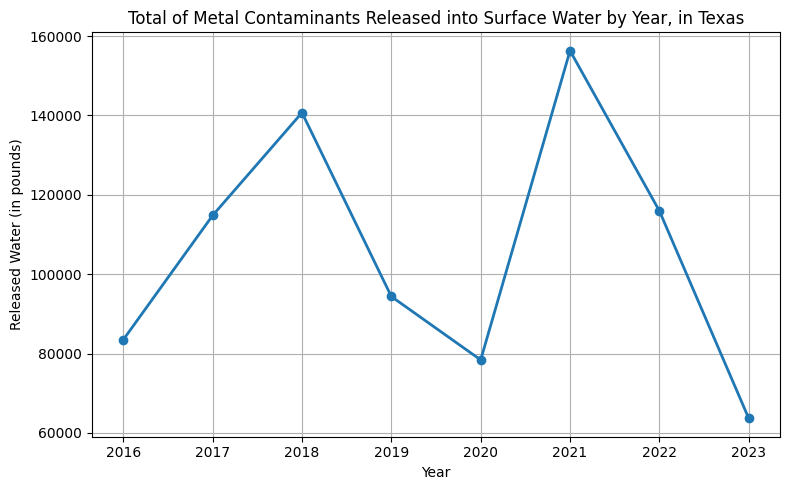

In [17]:
plt.figure(figsize=(8, 5))
plt.plot(water_release_by_year["year"], water_release_by_year["released_water"], marker="o", linewidth=2)
plt.title("Total of Metal Contaminants Released into Surface Water by Year, in Texas")
plt.xlabel("Year")
plt.ylabel("Released Water (in pounds)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df_clean[['year', 'trifd', 'frs_id', 'facility_name', 'street_address', 'city',
       'county', 'state', 'zip', 'zip+4', 'latitude', 'longitude',
       'horizontal_datum', 'parent_co_name', 'parent_co_db_num',
       'federal_facility', 'industry_sector_code', 'industry_sector',
       'chemical', 'elemental_metal_included', 'tri_chemical/compound_id',
       'classification', 'metal', 'metal_category', 'carcinogen',
       'unit_of_measure']].isnull().any()

year                        False
trifd                       False
frs_id                      False
facility_name               False
street_address              False
city                        False
county                      False
state                       False
zip                         False
zip+4                       False
latitude                    False
longitude                   False
horizontal_datum            False
parent_co_name               True
parent_co_db_num             True
federal_facility            False
industry_sector_code        False
industry_sector             False
chemical                    False
elemental_metal_included    False
tri_chemical/compound_id    False
classification              False
metal                       False
metal_category              False
carcinogen                  False
unit_of_measure             False
dtype: bool

In [10]:
df_clean[['released_water', 'total_population',
       'total_housing_units', 'housing_pre1980', 'median_household_income',
       'gini_index', 'white_alone', 'black_alone', 'asian_alone',
       'hispanic_alone', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic',
       'pct_pre1980_housing']].isnull().any()

released_water             False
total_population           False
total_housing_units        False
housing_pre1980            False
median_household_income    False
gini_index                 False
white_alone                False
black_alone                False
asian_alone                False
hispanic_alone             False
pct_white                  False
pct_black                  False
pct_asian                  False
pct_hispanic               False
pct_pre1980_housing        False
dtype: bool

In [11]:
df_clean.describe()

,year,frs_id,zip+4,latitude,longitude,parent_co_db_num,industry_sector_code,released_water,total_population,total_housing_units,housing_pre1980,median_household_income,gini_index,white_alone,black_alone,asian_alone,hispanic_alone,pct_white,pct_black,pct_asian,pct_hispanic,pct_pre1980_housing
count,3067.000000,3.067000e+03,3067.000000,3067.000000,3067.000000,2.291000e+03,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000
mean,2019.364526,1.100219e+11,25.958918,30.959243,-96.238545,2.356051e+08,451.887512,276.382790,20645.346267,7763.809586,3495.402348,62684.882367,0.414882,7921.232149,2888.050864,746.367134,8584.100098,0.425756,0.144576,0.026284,0.379830,0.479346
std,2.345309,2.483980e+07,275.633734,1.745066,1.638160,3.384535e+08,516.476289,2036.442237,15484.653685,5387.327202,2714.472767,25008.081001,0.047691,6996.297987,3588.720501,1978.092628,9849.996355,0.240798,0.151608,0.041907,0.236766,0.222455
min,2016.000000,1.100005e+11,0.000000,25.915560,-106.585052,1.024314e+06,311.000000,0.001000,986.000000,487.000000,0.000000,19758.333000,0.282000,7.000000,0.000000,0.000000,7.000000,0.002000,0.000000,0.000000,0.003000,0.000000
25%,2017.000000,1.100005e+11,0.000000,29.730280,-97.160944,6.985956e+06,325.000000,0.228000,9255.500000,3706.000000,1256.000000,45207.000000,0.382000,2532.000000,483.000000,44.000000,2145.000000,0.220500,0.039000,0.004000,0.179500,0.312000
50%,2019.000000,1.100127e+11,0.000000,30.172560,-95.867777,7.867528e+07,331.000000,2.530000,16969.000000,6704.000000,2992.000000,56920.357000,0.408000,6135.000000,1607.000000,202.000000,5240.000000,0.440000,0.098000,0.011000,0.333000,0.510000
75%,2021.000000,1.100358e+11,0.000000,32.702990,-95.126944,1.940815e+08,332.000000,23.000000,29432.000000,10657.000000,5054.500000,76314.214500,0.441500,11124.500000,3987.000000,631.000000,11504.000000,0.617000,0.186000,0.029000,0.534000,0.647000
max,2023.000000,1.100717e+11,3257.000000,35.951944,-93.734518,9.699621e+08,4247.000000,54755.560000,125566.000000,40408.000000,14090.000000,243401.833000,0.699000,50468.000000,34863.000000,30798.000000,83748.000000,0.948000,0.864000,0.344000,0.968000,0.957000


In [12]:
df_clean['gini_index'].isnull().any()

False

In [13]:
df_clean.to_csv("~/Documents/UH/hon4350/water_quality/data/main/main.csv")
df_clean.to_excel("~/Documents/UH/hon4350/water_quality/data/main/main.xlsx")